## Facial Emotion Recognition

In [1]:
# RUN to download the datasets
# wget https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/download?datasetVersionNumber=1

## Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image

2023-12-18 09:24:08.985880: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 09:24:09.040135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 09:24:09.040184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 09:24:09.040219: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 09:24:09.048450: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 09:24:10.128532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

## The different files names

In [3]:
image_data='/home/edwin/Facial_Emotion_Recognition/dataset/'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Angry
1,Surprise
2,Neutral
3,Ahegao
4,Sad
5,Happy


## Reading the data

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


## Checking the class labels

In [6]:
unique_labels = np.unique(data['label'])
print("Class Labels:", unique_labels)

Class Labels: ['Ahegao' 'Angry' 'Happy' 'Neutral' 'Sad' 'Surprise']


## Samplings some images

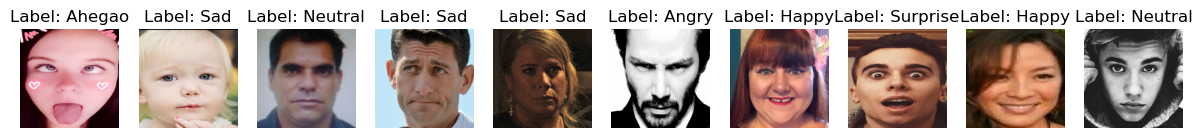

In [7]:
# Display some images
num_samples = 10
sample_indices = np.random.choice(len(data), num_samples, replace=False)

# Plot the images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices, 1):
    img = img_to_array(load_img('/home/edwin/Facial_Emotion_Recognition/dataset/' + data['path'][idx], target_size=(224, 224)))
    label = data['label'][idx]

    plt.subplot(1, num_samples, i)
    plt.imshow(img.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()

## Checking the size of images

In [8]:
# number of images to check
num_images_to_check = 5

# Print the size of each image
for idx in range(num_images_to_check):
    img_path = '/home/edwin/Facial_Emotion_Recognition/dataset/' + data['path'][idx]
    img = img_to_array(load_img(img_path, target_size=(224, 224)))
    print(f"Image {idx + 1} size: {img.shape}")

Image 1 size: (224, 224, 3)
Image 2 size: (224, 224, 3)
Image 3 size: (224, 224, 3)
Image 4 size: (224, 224, 3)
Image 5 size: (224, 224, 3)


## The Distribution of emotions in the dataset

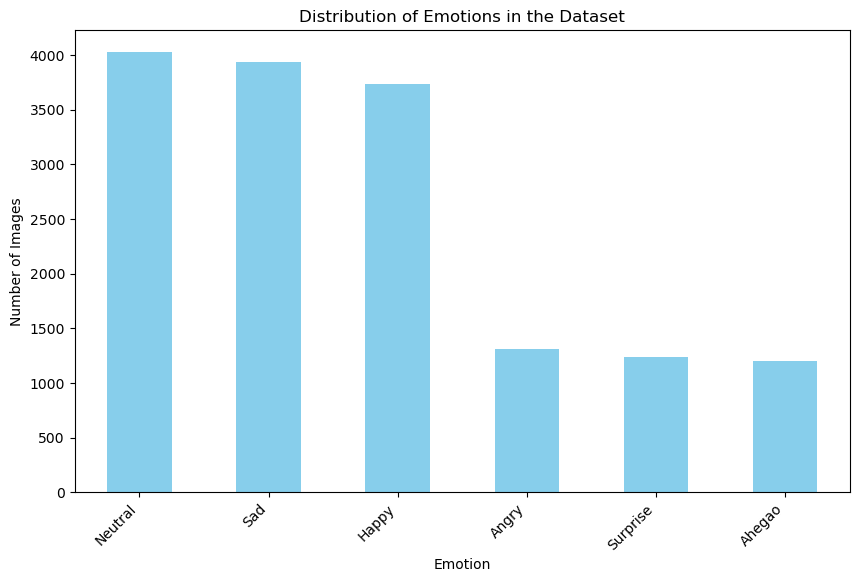

In [9]:
# Count occurrences of each emotion in the dataset
emotion_counts = data['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.show()

## Load and preprocess Images

In [10]:
# Define a generator function to load and preprocess images in batches
def data_generator(data, batch_size=32):
    num_samples = len(data)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        X_batch = np.array([img_to_array(load_img('/home/edwin/Facial_Emotion_Recognition/dataset/' + img, target_size=(224, 224))) for img in data['path'].iloc[indices]])
        y_batch = LabelEncoder().fit_transform(data['label'].iloc[indices])
        yield X_batch, y_batch

## represent categorical variables as binary vectors
### one-hot encoding

In [11]:
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])

In [12]:
# Convert the encoded labels to one-hot encoding
one_hot_labels = to_categorical(data['encoded_label'], num_classes=6)
print(one_hot_labels)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [13]:
# Update the 'label' column with the original class labels
data['label'] = label_encoder.inverse_transform(data['encoded_label'])

## Spliting the dataset

In [14]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [16]:
num_train_samples = len(train_data)
num_val_samples = len(val_data)  # Replace with your actual validation data split
num_test_samples = len(test_data)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of testing samples: {num_test_samples}")

Number of training samples: 9889
Number of validation samples: 2473
Number of testing samples: 3091


In [35]:
# Create an image data generator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

## preprocess the validation and test datasets

In [18]:
# Create an image data generator without augmentation for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create an image data generator without augmentation for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

sample_generator = data_generator(train_data, batch_size=32)
X_sample, y_sample = next(sample_generator)

# If your labels are not one-hot encoded, you can directly use them
# Convert categorical labels to numerical indices
y_sample_indices = y_sample

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_sample_indices), y=y_sample_indices)

# Create a dictionary to be used as class_weight parameter in the generator
class_weight_dict = dict(enumerate(class_weights))


## setting up a training data generator

In [21]:
batch_size = 8
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/home/edwin/Facial_Emotion_Recognition/dataset/',
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    class_weight=class_weight_dict
)

Found 9889 validated image filenames belonging to 6 classes.


## setting up a validation data generator

In [22]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='/home/edwin/Facial_Emotion_Recognition/dataset/',
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2473 validated image filenames belonging to 6 classes.


## setting up a test data generator

In [23]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/home/edwin/Facial_Emotion_Recognition/dataset/',
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3091 validated image filenames belonging to 6 classes.


In [24]:
print("Shape of y (training):", next(train_generator)[1].shape)

print("Shape of y (validation):", next(val_generator)[1].shape)
print("Shape of y (testing):", next(test_generator)[1].shape)

Shape of y (training): (8, 6)
Shape of y (validation): (8, 6)
Shape of y (testing): (8, 6)


## Load the pre-trained ResNet50 model

In [25]:
# Load the pre-trained ResNet50 model without including the top (fully connected) layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [26]:
# fine-tuning unfreezing the last few layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = False

In [27]:
# !pip install tensorflow-hub

In [28]:
# Create model on top of the base model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])

In [30]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Training the model

In [33]:
# Check class indices
print("Class Indices:", train_generator.class_indices)

# Check class weights
print("Class Weights:", class_weight_dict)

# Check a batch from the generator
sample_batch = next(train_generator)
print("Sample Batch Shape:", sample_batch[0].shape)  # Input data shape
print("Sample Labels:", sample_batch[1])

Class Indices: {'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}
Class Weights: {0: 2.1333333333333333, 1: 1.28, 2: 0.5333333333333333, 3: 0.5818181818181818, 4: 6.4}
Sample Batch Shape: (8, 224, 224, 3)
Sample Labels: [[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [ ]:

# Train
history_fine_tuned = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

## Evaluate on the test

In [ ]:
# Evaluate the model on the test set
score = model.evaluate(test_generator, steps=len(test_generator), verbose=0)

# Print the test loss and accuracy
print('Test Loss =', score[0])
print('Test Accuracy =', score[1])

# Predict the classes for the test set
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Evaluate on the validation

In [ ]:
# Evaluate the model on the validation set
val_score = model.evaluate(val_generator, steps=len(val_generator), verbose=0)

# Print the validation loss and accuracy
print('Validation Loss =', val_score[0])
print('Validation Accuracy =', val_score[1])

# Predict the classes for the validation set
y_val_true = val_generator.classes
y_val_pred_prob = model.predict(val_generator, steps=len(val_generator))
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# Print classification report for the validation set
print("\nValidation Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))


## Saving the entire model

In [39]:
# Save
model.save('Ai_emotion_model_V1.h5')

/home/edwin/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Loading the model

In [3]:
# Load the model with custom object scope
with tf.keras.utils.custom_object_scope({'KerasLayer': hub.KerasLayer}):
    model = load_model('Ai_emotion_model_V1.h5')

1/1 [==============================] - 1s 1s/step
Predicted class: [2]


## classifying an image

In [47]:
# Load and preprocess the input image
img_path = 'cropped_emotions.570200.png'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target_size if needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 53ms/step
Predicted class: [4]


In [12]:

# Map the predicted class to the corresponding one-hot encoded label
predicted_one_hot_label = to_categorical(predicted_class, num_classes=6)

# Reverse the one-hot encoding to get the original encoded label
predicted_encoded_label = np.argmax(predicted_one_hot_label)

# Reverse the LabelEncoder to get the original emotion label
predicted_emotion = label_encoder.inverse_transform([predicted_encoded_label])[0]
print("Predicted emotion:", predicted_emotion)


Predicted emotion: Happy


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4214306 (16.08 MB)
Trainable params: 164742 (643.52 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


## Continue training 

In [37]:
# Continue training for additional epochs
additional_epochs = 5

history_additional_training = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=additional_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

# Save the model after additional training
model.save('your_updated_model.h5')

Epoch 1/5
1237/1237 [==============================] - 458s 357ms/step - loss: 0.6915 - accuracy: 0.7229 - val_loss: 0.9085 - val_accuracy: 0.6526
Epoch 2/5
1237/1237 [==============================] - 433s 350ms/step - loss: 0.6852 - accuracy: 0.7237 - val_loss: 0.9365 - val_accuracy: 0.6535
Epoch 3/5
1237/1237 [==============================] - 411s 332ms/step - loss: 0.6692 - accuracy: 0.7286 - val_loss: 0.9459 - val_accuracy: 0.6446
Epoch 4/5
1237/1237 [==============================] - 415s 336ms/step - loss: 0.6573 - accuracy: 0.7373 - val_loss: 0.9091 - val_accuracy: 0.6535
Epoch 5/5
1237/1237 [==============================] - 419s 339ms/step - loss: 0.6290 - accuracy: 0.7525 - val_loss: 0.9304 - val_accuracy: 0.6599


/home/edwin/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# Load the model with a custom object scope
with tf.keras.utils.custom_object_scope({'KerasLayer': hub.KerasLayer}):
    model = load_model('Ai_emotion_model_V2.h5')

In [64]:
# Load and preprocess the input image
img_path = 'cropped_emotions.16220~ahegao.png'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target_size if needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 50ms/step
Predicted class: [2]


In [65]:
# Map the predicted class to the corresponding one-hot encoded label
predicted_one_hot_label = to_categorical(predicted_class, num_classes=6)

# Reverse the one-hot encoding to get the original encoded label
predicted_encoded_label = np.argmax(predicted_one_hot_label)

# Reverse the LabelEncoder to get the original emotion label
predicted_emotion = label_encoder.inverse_transform([predicted_encoded_label])[0]
print("Predicted emotion:", predicted_emotion)


Predicted emotion: Happy
